# Time Series Forcasting 

Time Series (TS) is a collection of data points collected at **constant time intervals**. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. 

- But what makes a TS different from say a regular regression problem? There are 2 things:
<br></br><br></br>
    - It is **time dependent**. 
        - So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
<br></br><br></br>
    - Along with an increasing or decreasing trend, most TS have some form of **seasonality trends**, i.e. variations specific to a particular time frame. 
        - For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.


Because of the inherent properties of a TS, there are various steps involved in analyzing it. These are discussed in detail below. Lets start by loading a TS object in Python. We’ll be using the popular AirPassengers data set (https://www.kaggle.com/rakannimer/air-passengers)

## Loading and Handling Time Series in Pandas

Pandas has dedicated libraries for handling TS objects, particularly the datatime64[ns] class which stores time information and allows us to perform some operations really fast. Lets start by firing up the required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10

Now, we lets load the data set and look at some initial rows and data types of the columns:

In [4]:
data = pd.read_csv('./time-series-data/AirPassengers.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


The data contains a particular month and number of passengers travelling in that month. But this is still not read as a TS object as the data types are ‘object’ and ‘int’. In order to read the data as a time series, we have to pass special arguments to the read_csv command:

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('./time-series-data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print (data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


<ipython-input-5-74a28b5c3c29>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


Let’s understand the arguments one by one:
<br></br>
<br></br>
- `parse_dates`: This specifies the column which contains the date-time information. As we say above, the column name is ‘Month’.
<br></br>
<br></br>
- `index_col`: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.
<br></br>
<br></br>
- `date_parser`: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined. Something similar to the dataparse function defined here can be used for this purpose.


Now we can see that the data has time object as index and #Passengers as the column. We can cross-check the datatype of the index with the following command:

In [6]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Notice the `dtype=’datetime[ns]’` which confirms that it is a datetime object. Lets convert the column into a Series object to prevent referring to columns names every time we use the TS. 

In [7]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

Lets start by selecting a particular value in the Series object. This can be done in following 2 ways:

In [8]:
#1. Specific the index as a string constant:
ts['1949-01-01']

#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(1949,1,1)]

112

Both would return the value ‘112’ which can also be confirmed from previous output. Suppose we want all the data upto May 1949. This can be done in 2 ways:

In [9]:
#1. Specify the entire range:
ts['1949-01-01':'1949-05-01']

#2. Use ':' if one of the indices is at ends:
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

There are 2 things to note here:
<br></br>
<br></br>
- Unlike numeric indexing, the end index is included here. For instance, if we index a list as a[:5] then it would return the values at indices – [0,1,2,3,4]. But here the index ‘1949-05-01’ was included in the output.
<br></br>
<br></br>
- The indices have to be sorted for ranges to work. If you randomly shuffle the index, this won’t work.


Consider another instance where you need all the values of the year 1949. This can be done as:

In [10]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

The month part was omitted. Similarly if you all days of a particular month, the day part can be omitted.

Now, lets move onto the analyzing the TS.

## Check Stationarity of a Time Series (TS)

A TS is said to be **stationary** if its statistical properties such as mean, variance remain **constant over time**.

- But why is it important? 
<br></br>
<br></br>
    - Most of the TS models work on the assumption that the TS is stationary. 
    <br></br>
<br></br>
        - Intuitively, we can state that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
        <br></br>
<br></br>
        - Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, i.e. the following:
<br></br>
<br></br>
- **constant mean**
<br></br>
<br></br>
- **constant variance**
<br></br>
<br></br>
- an **autocovariance** that does not depend on time.


### Stationary Series

Lets try to understand the three basic criterions for a time-series to be classified as stationary series:

- **Constant Mean** - The mean of the series should not be a function of time rather should be a constant. The image below has the left hand graph satisfying the condition whereas the graph in red has a time dependent mean.

<center>
<div id="container"> <img src="./images/ts1.png" class="center" alt="Time Series" style="width: 1000px;"/> 
</center>

- **Constant Variance** - The variance of the series should not a be a function of time. This property is known as homoscedasticity. Following graph depicts what is and what is not a stationary series. (Notice the varying spread of distribution in the right side graph)

<center>
<div id="container"> <img src="./images/ts2.png" class="center" alt="Time Series" style="width: 1000px;"/> 
</center>

- **Covariance** - The covariance of the i-th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’.

<center>
<div id="container"> <img src="./images/ts3.png" class="center" alt="Time Series" style="width: 1000px;"/> 
</center>

#### Why do we care about ‘stationarity’ of a time series?

In cases where the stationary criterion are violated, the first requisite becomes to stationarize the time series and then try stochastic models to predict this time series. There are multiple ways of bringing this stationarity. Some of them are Detrending, Differencing etc.

Lets take an example:
    <br></br>
<br></br>

- Example: Imagine a girl moving randomly on a giant chess board. In this case, next position of the girl is only dependent on the last position.
    
<center>
<div id="container"> <img src="./images/ts4.gif" class="center" alt="Time Series" style="width: 700px;"/> 
</center>

- Now imagine, you are sitting in another room and are not able to see the girl. 
    <br></br>
<br></br>
    - You want to predict the position of the girl with time. How accurate will you be? 
        <br></br>
<br></br>
        - Of course you will become more and more inaccurate as the position of the girl changes. 
        - At t=0 you exactly know where the girl is. Next time, she can only move to 8 squares and hence your probability dips to 1/8 instead of 1 and it keeps on going down. 
    <br></br>
<br></br>        


- Now let’s try to formulate this series :
$$X(t) = X(t-1) + Er(t)$$

where $Er(t)$ is the error at time point $t$. This is the randomness the girl brings at every point in time.

Now, if we recursively fit in all the $X$s, we will finally end up to the following equation :

$$X(t) = X(0) + Sum(Er(1),Er(2),Er(3).....Er(t))$$

Now, lets try validating our assumptions of stationary series on this random walk formulation:

#### 1. Is the Mean constant ?
$$E[X(t)] = E[X(0)] + Sum(E[Er(1)],E[Er(2)],E[Er(3)].....E[Er(t)])$$

We know that Expectation of any Error will be zero as it is random.

Hence we get $$E[X(t)] = E[X(0)] = Constant$$

#### 2. Is the Variance constant?

$$Var[X(t)] = Var[X(0)] + Sum(Var[Er(1)],Var[Er(2)],Var[Er(3)].....Var[Er(t)])$$

$$Var[X(t)] = t * Var(Error) = Time dependent$$

Hence, we infer that the random walk is not a stationary process as it has a time variant variance. Also, if we check the covariance, we see that too is dependent on time.

#### Lets look at it from a different prespective 

We already know that a random walk is a non-stationary process. Let us introduce a new coefficient in the equation to see if we can make the formulation stationary.

- **Introduced coefficient** : $\rho$

$$X(t) = \rho * X(t-1) + Er(t)$$

Now, we will vary the value of Rho ($\rho$) to see if we can make the series stationary. Here we will interpret the scatter visually and not do any test to check stationarity.

Let’s start with a perfectly stationary series with $\rho = 0$ . 

$$X(t) = Er(t)$$

Here is the plot for the time series :

<center>
<div id="container"> <img src="./images/ts5.png" class="center" alt="Time Series" style="width: 700px;"/> 
</center>

Increase the value of $\rho$ to 0.5 gives us following graph :

$$X(t) = 0.5 * X(t-1) + Er(t)$$

<center>
<div id="container"> <img src="./images/ts6.png" class="center" alt="Time Series" style="width: 700px;"/> 
</center>

You might notice that our cycles have become broader but essentially there does not seem to be a serious violation of stationary assumptions. Let’s now take a more extreme case of $\rho = 0.9$

<center>
<div id="container"> <img src="./images/ts7.png" class="center" alt="Time Series" style="width: 700px;"/> 
</center>

We still see that the X returns back from extreme values to zero after some intervals. This series also is not violating non-stationarity significantly. Now, let’s take a look at the random walk with $\rho = 1$.

<center>
<div id="container"> <img src="./images/ts8.png" class="center" alt="Time Series" style="width: 700px;"/> 
</center>

This obviously is an violation to stationary conditions. What makes rho = 1 a special case which comes out badly in stationary test? We will find the mathematical reason to this.

Let’s take expectation on each side of the equation - $X(t) = \rho * X(t-1) + Er(t)$

$$E[X(t)] = \rho *E[ X(t-1)]$$

This equation is very insightful. The next $X$ (or at time point $t$) is being pulled down to $\rho$ * Last value of X.


For instance, if $X(t – 1 ) = 1, E[X(t)] = 0.5$ ( for $\rho = 0.5$). Now, if $X$ moves to any direction from zero, it is pulled back to zero in next step. The only component which can drive it even further is the error term. Error term is equally probable to go in either direction. What happens when the Rho becomes 1? No force can pull the X down in the next step.

#### Dickey Fuller Test of Stationarity

What we just learnt in the last section is formally known as Dickey Fuller test. Here is a small tweak which is made for our equation to convert it to a Dickey Fuller test:

$$X(t) = \rho * X(t-1) + Er(t)$$


$$\implies  X(t) - X(t-1) = (\rho - 1) * X(t - 1) + Er(t)$$

We have to test if $\rho - 1$ is significantly different than zero or not. 
    <br></br>
<br></br>
- ***If the null hypothesis gets rejected, we’ll get a stationary time series.***


### Back to our data

Lets move onto the ways of testing stationarity. First and foremost is to simple plot the data and analyze visually. The data can be plotted using following command:

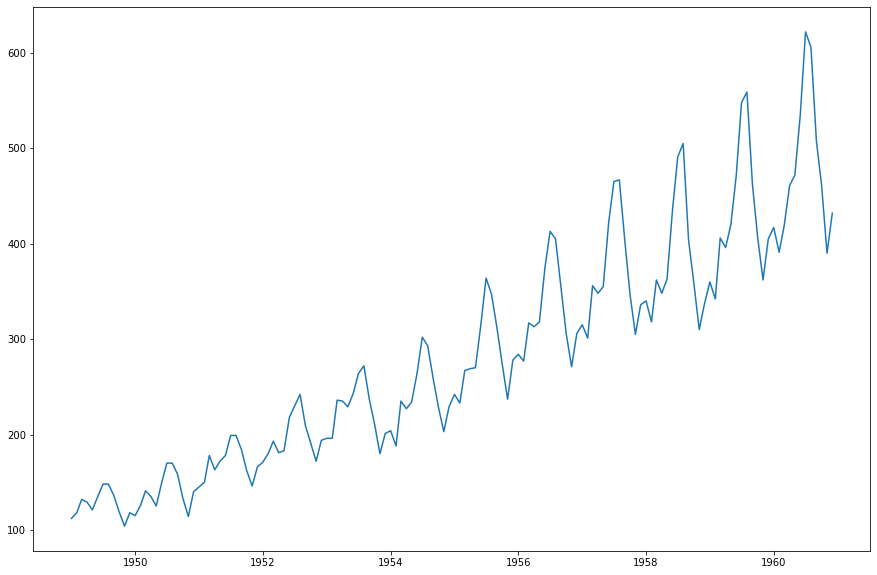

In [11]:
plt.plot(ts)

It is clearly evident that there is an overall increasing trend in the data along with some *seasonal variations*. However, it might not always be possible to make such visual inferences (we’ll see such cases later). So, more formally, we can check stationarity using the following:


- **Plotting Rolling Statistics**: We can plot the moving average or moving variance and see if it varies with time. 
    - **moving average/variance** -  At any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
<br></br>
<br></br>
- **Dickey-Fuller Test**: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a ***Test Statistic*** and some ***Critical Values*** for difference confidence levels. 
    - If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.


- We’ll be using the rolling statistics plots along with Dickey-Fuller test results.
<br></br>
<br></br>
    - The function below takes a TS as input and generates the test results. 
        - Please note that standard deviation is plotted instead of variance to keep the unit similar to mean.
    - You would need `statsmodels` package for further timeseries analysis

In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Let’s run it for our input series:

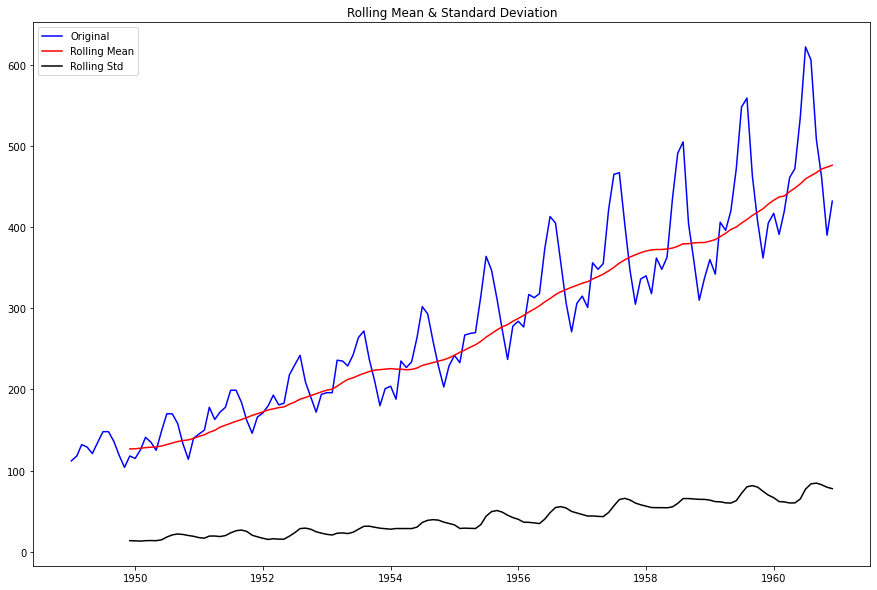

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
test_stationarity(ts)

#### Observations 

- Though the variation in standard deviation is small, *mean is clearly increasing with time and this is not a stationary series*. 
<br></br>
<br></br>
- Also, the test statistic is way more than the critical values. 
    - Note that the signed values should be compared and not the absolute values.

## How to make a Time Series Stationary?

- Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. 
<br></br>
<br></br>
    - its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

- Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationarity of a TS:
    <br></br>
<br></br>
    1. **Trend** – varying mean over time. 
        - For ex: in this case we saw that on average, the number of passengers was growing over time.
    <br></br>
<br></br>
    2. **Seasonality** – variations at specific time-frames.
        - For ex: people might have a tendency to buy cars in a particular month because of pay increment or festivals. Similar with travel, where there are travel seasons.

- The underlying principle is:
    <br></br>
<br></br>
    <center><b>to model or estimate the trend and seasonality and remove those to get a stationary time series.</b></center> 
<br></br>
<br></br>
- Then statistical forecasting techniques can be implemented on this series. 
    <br></br>
<br></br>
- The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

### Estimating & Eliminating Trend

- One of the first tricks to reduce trend can be **transformation**. 
<br></br>
<br></br>
    - For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. 
    
    
    
Lets take a **log transform** here for simplicity:

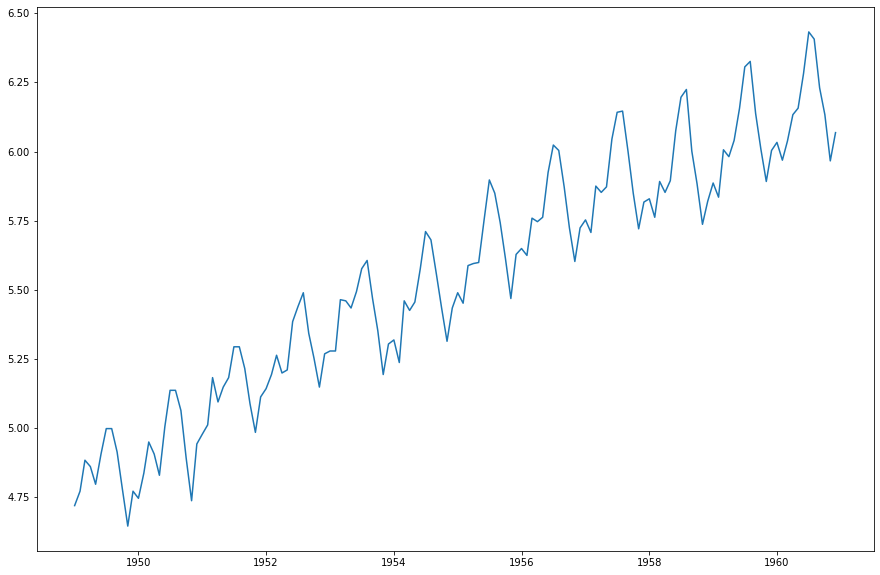

In [15]:
ts_log = np.log(ts)
plt.plot(ts_log)

In this simpler cases, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:
<br></br>
<br></br>
- **Aggregation** – taking average for a time period like monthly/weekly averages
<br></br>
<br></br>
- **Smoothing** – taking rolling averages
<br></br>
<br></br>
- **Polynomial Fitting** – fit a regression model


#### Moving average (Simple Moving Average)

In this approach, we take average of $k$ consecutive values depending on the frequency of time series. 
<br></br>
<br></br>
- Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

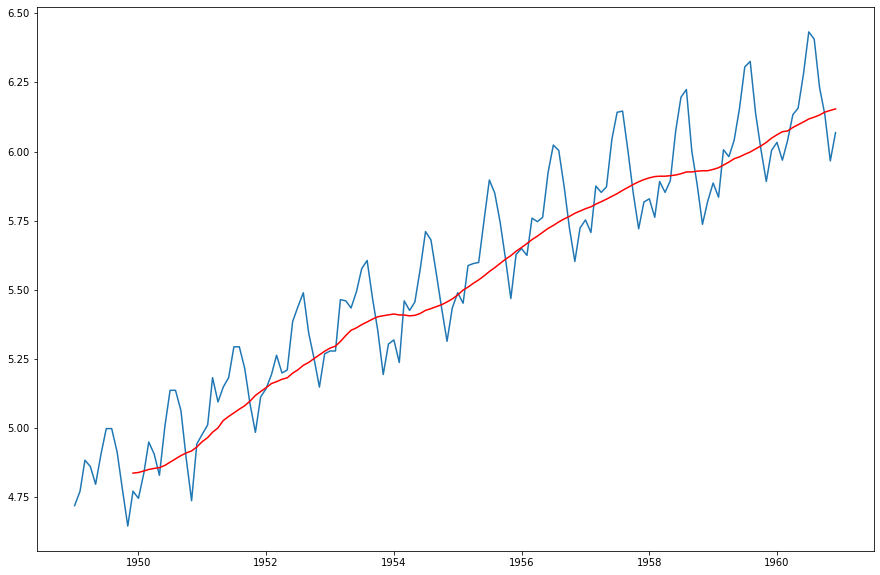

In [16]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [17]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

Notice the first 11 being Nan. Lets drop these NaN values and check the plots to test stationarity.

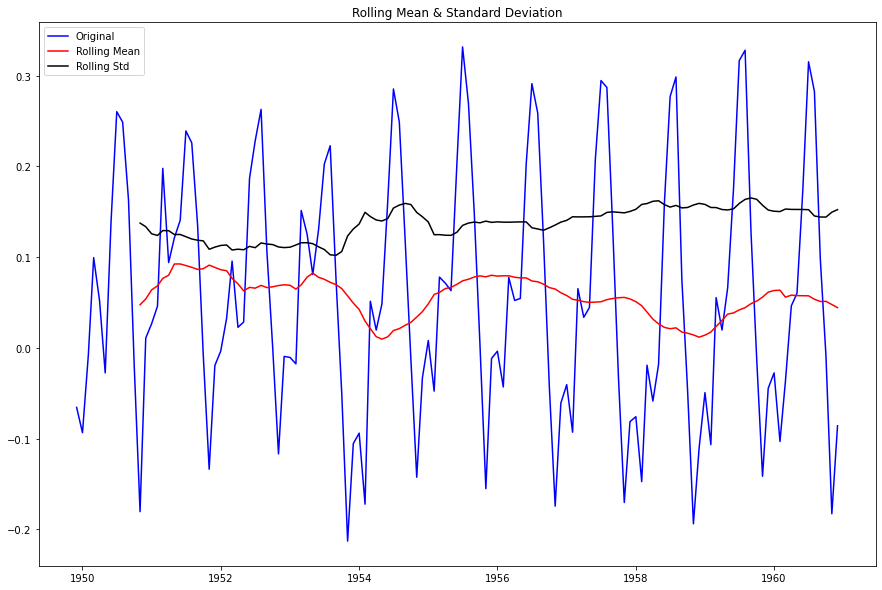

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [18]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

- This looks like a much better series. 
<br></br>
<br></br>
    - The rolling values appear to be varying slightly but there is no specific trend. 
    <br></br>
<br></br>
    - Also, the test statistic is ***smaller than the 5% critical values*** - so we can say with 95% confidence that this is a stationary series.

- However, a drawback in this particular approach is that the time-period has to be strictly defined. 
<br></br>
<br></br>
    - In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. 
    <br></br>
<br></br>
    - So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many techniques for assigning weights. 
    <br></br>
<br></br>


#### Exponential Moving average (EMA)

A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

$$S_t = \begin{cases} Y_1, & t=1 \\ \alpha * Y_t + (1-\alpha) * S_{t-1}, & t > 1 \end{cases}$$


- The coefficient $\alpha$ represents the degree of weighting decrease (smoothing factor), a constant smoothing factor between 0 and 1. A higher $\alpha$ discounts older observations faster.
- $Y_t$ is the value at a time period t.
- $S_t$is the value of the EMA at any time period t.


- Find details [http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions]. 
    
This can be implemented in Pandas as:

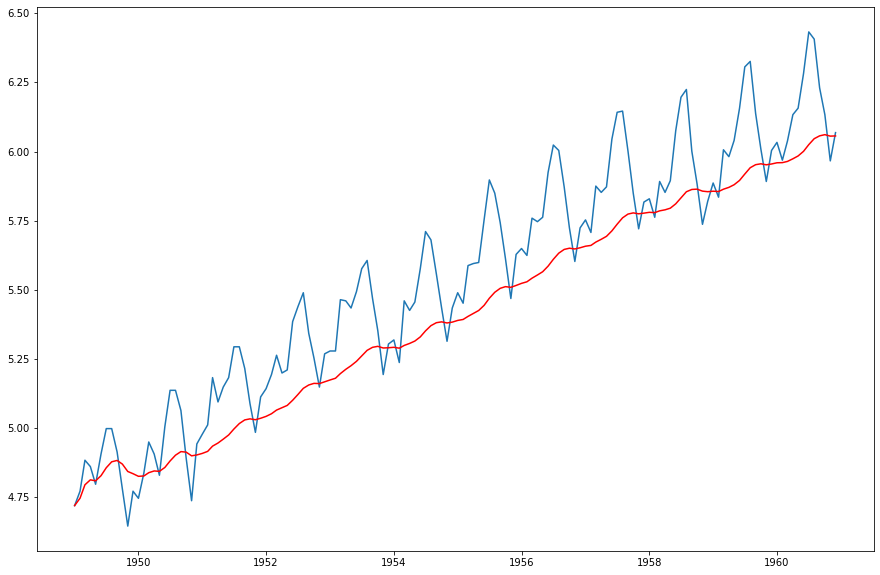

In [19]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above. Now, let’s remove this from series and check stationarity:

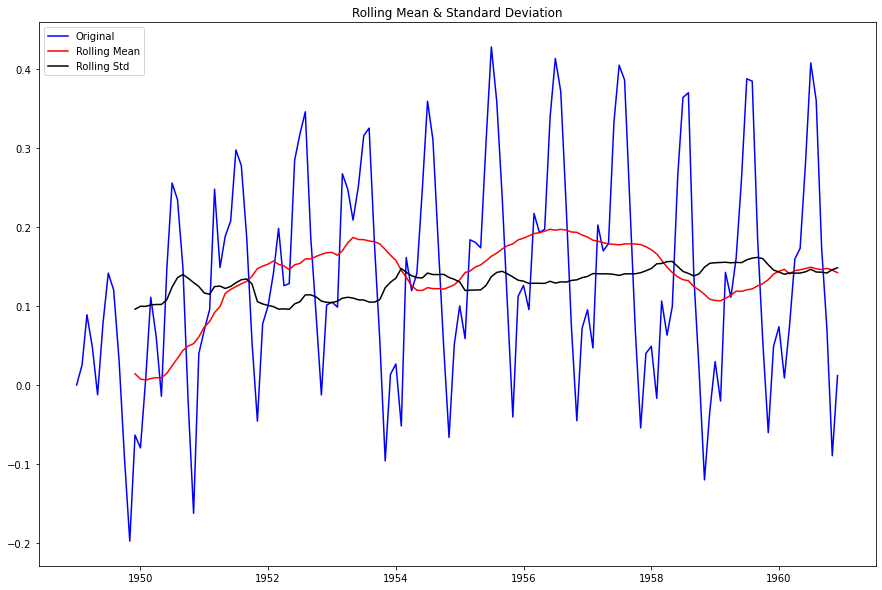

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is ***smaller than the 1% critical value***, which is better than the previous case. 
<br></br>
<br></br>

- Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

## Eliminating Trend and Seasonality


The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:
<br></br>
<br></br>
- Differencing – taking the difference with a particular time lag
<br></br>
<br></br>
- Decomposition – modeling both trend and seasonality and removing them from the model.


### Differencing

- One of the most common methods of dealing with both trend and seasonality is differencing.
<br></br>
<br></br>
- In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 
    - This mostly works well in improving stationarity. 
<br></br>
<br></br>   
- First order differencing can be done in Pandas as:

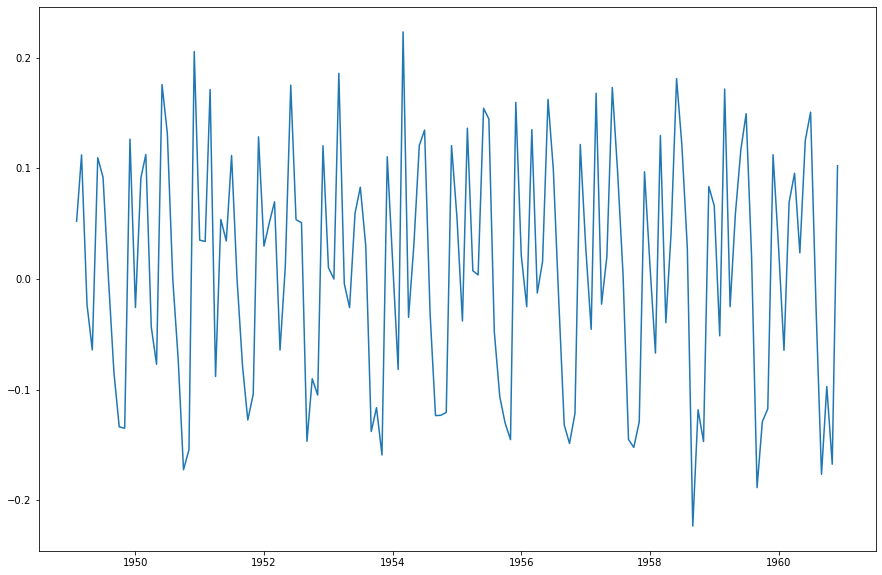

In [21]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

This appears to have reduced trend considerably. Lets verify using our plots:

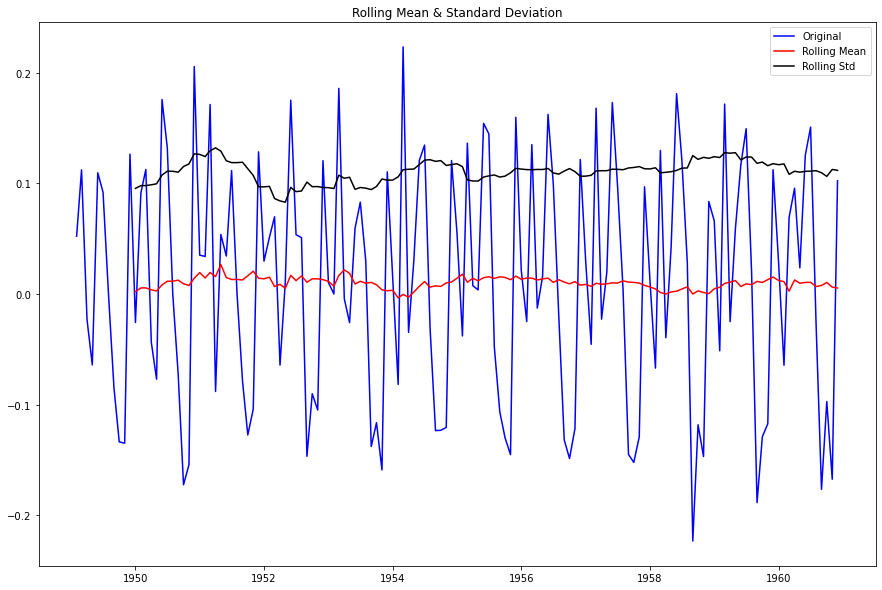

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [22]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

- We can see that the mean and std variations have small variations with time. 
<br></br>
<br></br>
- The Dickey-Fuller test statistic is **less than the 10% critical value**, thus the TS is stationary with 90% confidence. 
<br></br>
<br></br>
- We can also take second or third order differences which might get even better results in certain applications. I leave it to you to try them out.

### Decomposing

- In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. 

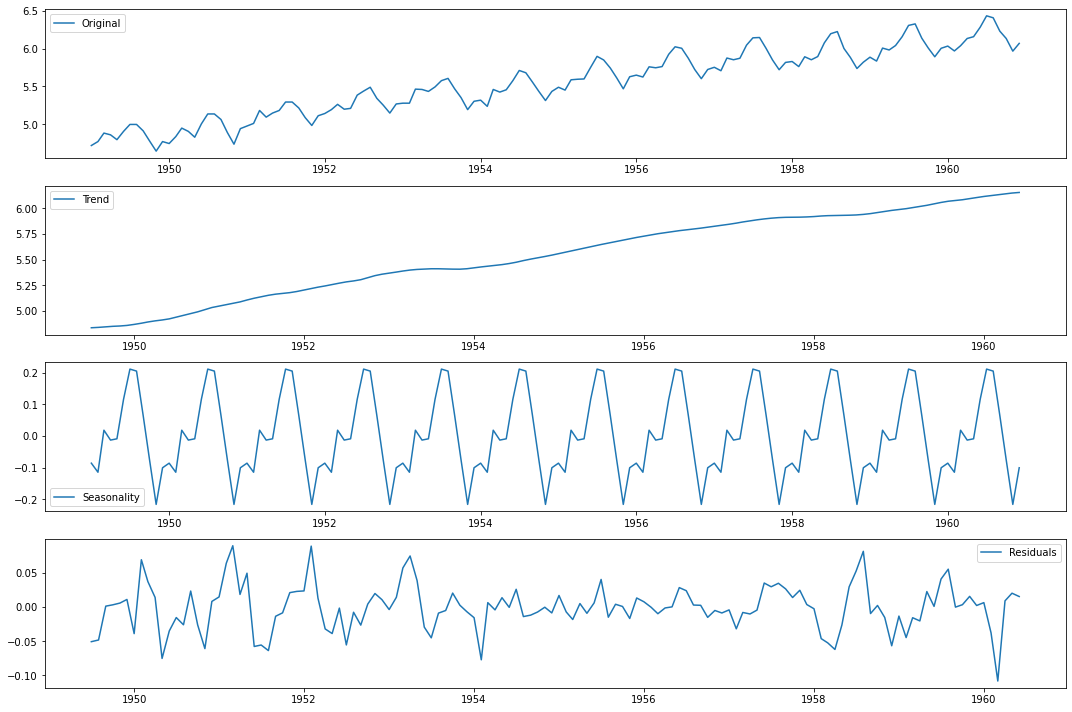

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

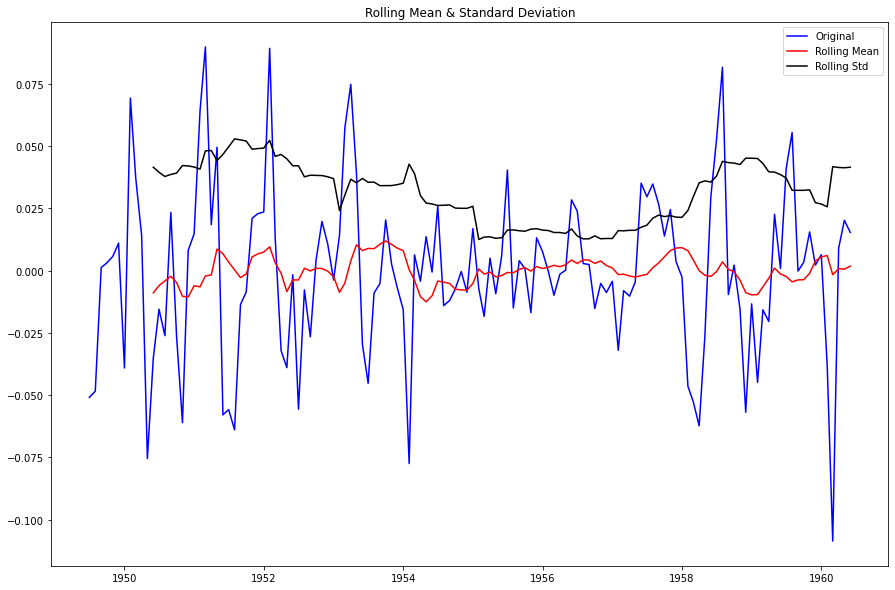

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [24]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

- The Dickey-Fuller test statistic is **significantly lower than the 1% critical value**. 
<br></br>
<br></br>
- So this TS is very close to stationary. 
<br></br>
<br></br>
- Also, you should note that converting the residuals into original values for future data in not very intuitive in this case.

## Forecasting a Time Series

We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique.


Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:


- A **strictly stationary** series with no dependence among the values. 
    - This is the easy case wherein we can model the residuals as white noise. But this is very rare.

<br></br>
<br></br>
- A series with **significant dependence among values**. 
    - In this case we need to use some statistical models like ARIMA to forecast the data.


### ARIMA - Auto-Regressive Integrated Moving Averages

- The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. 
<br></br>
<br></br>
- The predictors depend on the parameters (p,d,q) of the ARIMA model:


1. Number of AR (Auto-Regressive) terms ($p$): AR terms are just lags of dependent variable. 
    - For instance if $p$ is 5, the predictors for $x(t)$ will be $x(t-1) \cdots x(t-5)$.
<br></br>
<br></br>

2. Number of MA (Moving Average) terms ($q$): MA terms are lagged forecast errors in prediction equation. 
    - For instance if $q$ is 5, the predictors for x(t) will be $e(t-1) \cdots e(t-5)$ where $e(i)$ is the difference between the moving average at $i^{th}$ instant and actual value.
<br></br>
<br></br>
3. Number of Differences ($d$): These are the number of nonseasonal differences.
    - For instance, in this case we took the first order difference. So either we can pass that variable and put $d=0$ or pass the original variable and put $d=1$. Both will generate same results.


- An importance concern here is how to determine the value of $p$ and $q$. We use two plots to determine these numbers. Lets discuss them first.
<br></br>
<br></br>
    - **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. 
        - For instance at lag 5, ACF would compare series at time instant $t1 \cdots t2$ with series at instant $(t1-5) \cdots (t2-5)$ ($t1-5$  and  $t2$ being end points).
  <br></br>
<br></br>      
    - **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. 
        - For instance at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


The ACF and PACF plots for the TS after differencing can be plotted as:

/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function')

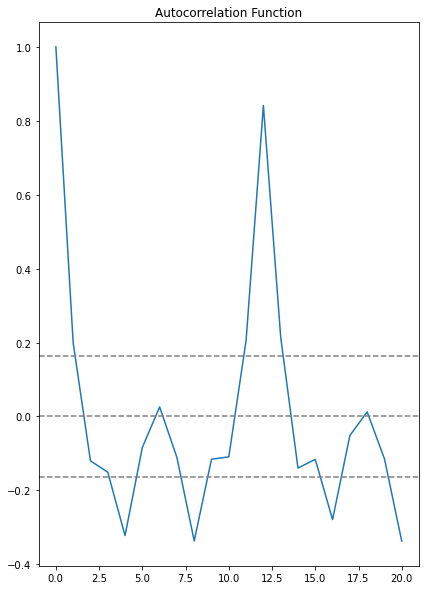

In [25]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

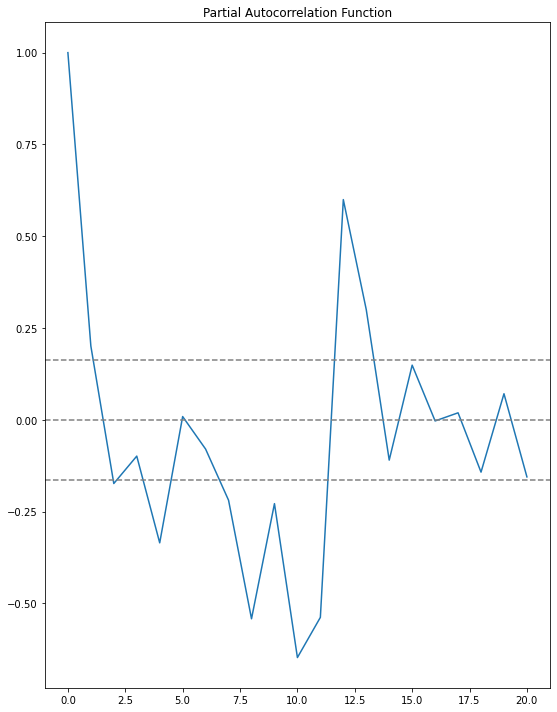

In [26]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the **$p$** and **$q$** values as:
<br></br>
<br></br>
- **$p$** – The lag value where the **PACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case $p=2$.
<br></br>
<br></br>
- **$q$** – The lag value where the **ACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case $q=2$.


Now, lets make 3 different ARIMA models considering individual as well as combined effects.



We need to load the ARIMA model first:

In [27]:
from statsmodels.tsa.arima_model import ARIMA

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

### AR Model

/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

Text(0.5, 1.0, 'RSS: 1.5023')

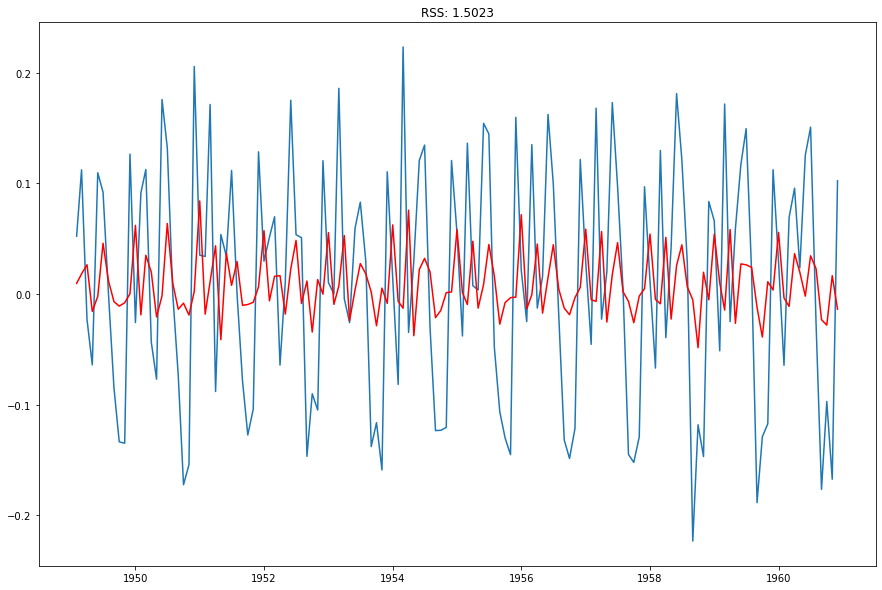

In [28]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model

/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 1.4721')

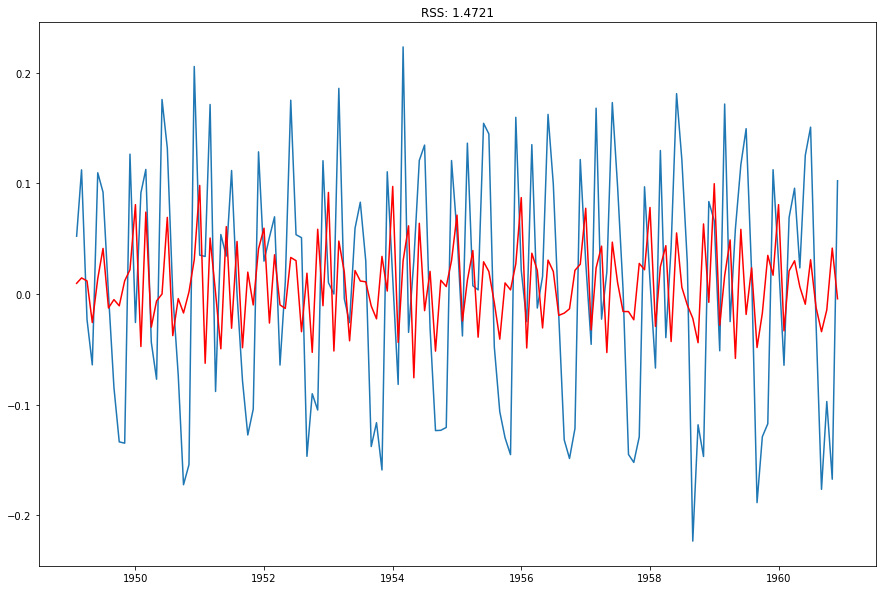

In [29]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Combined Model

/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA un

Text(0.5, 1.0, 'RSS: 1.0292')

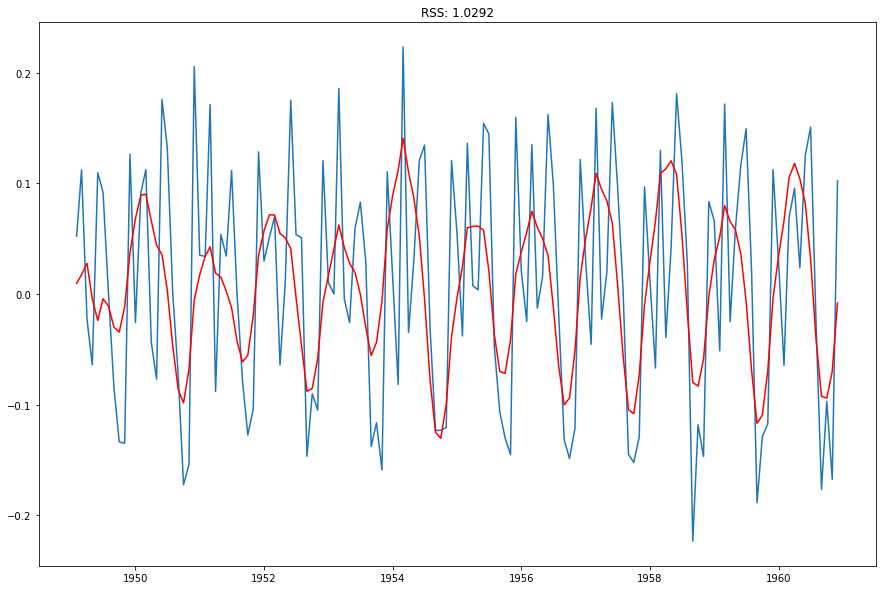

In [30]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

- Here we can see that the AR and MA models have almost the same RSS (Residual Sum Squares) but combined is significantly better. 



- Now, we are left with 1 last step, i.e. taking these values back to the original scale.

### Taking it back to original scale

- Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. 
  <br></br>
<br></br> 
    - First step would be to store the predicted results as a separate series and observe it.

In [32]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


- Notice that these start from ‘1949-02-01’ and not the first month. 
  <br></br>
<br></br>
    - Why? 
      <br></br>
    <br></br>
        - This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. 
<br></br>
<br></br>
- The way to convert the differencing to log scale is to add these differences consecutively to the base number. 
<br></br>
<br></br>
- An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [35]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


- Next we’ve to add them to base number. 
<br></br>
<br></br>
    - For this lets create a series with all values as base number and add the differences to it. 
    - This can be done as:

In [36]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

- Here the first element is base number itself and from thereon the values cumulatively added. 

- Last step is to take the exponent and compare with the original series.

Text(0.5, 1.0, 'RMSE: 90.1045')

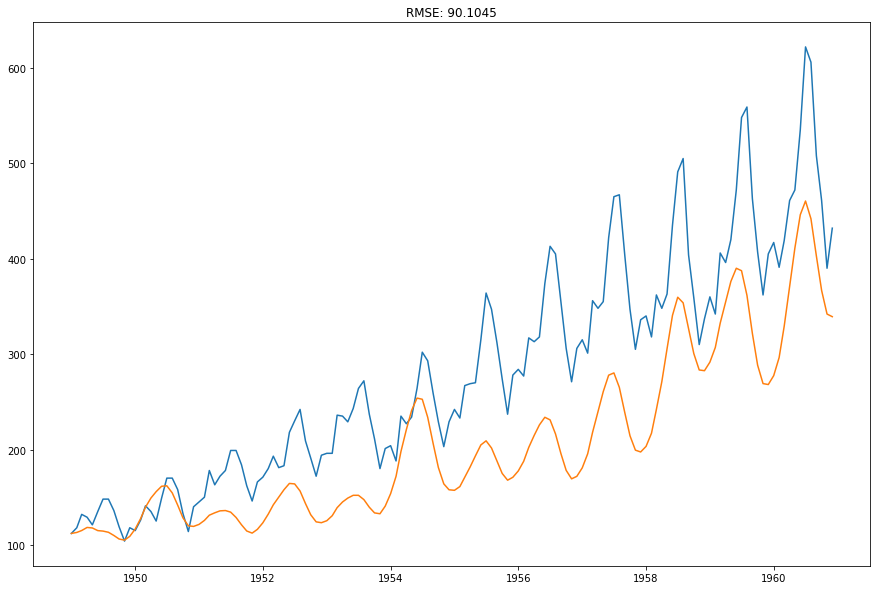

In [37]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Finally we have a forecast at the original scale. Not a very good forecast we would say but you got the idea right?

Reference: [*](https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb)

More References: 
1. https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
2. http://pythondata.com/forecasting-time-series-data-with-prophet-part-1/
3. https://bicorner.com/2015/11/16/time-series-analysis-using-ipython/